In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from datasets import DatasetDict

ds_path = "/mnt/ceph/users/sgolkar/datasets/astroclip/spec_chunked_ds"
ds = DatasetDict.load_from_disk(ds_path)

In [3]:
from fillm.run.model import *

def load_model_from_ckpt(ckpt_path: str):
    """
    Load a model from a checkpoint.
    """
    if Path(ckpt_path).is_dir():
        ckpt_path = Path(ckpt_path) / "ckpt.pt"

    chkpt = torch.load(ckpt_path)
    config = chkpt["config"]
    state_dict = chkpt["model"]
    model_name = config["model"]['kind']
    model_keys = get_model_keys(model_name)
    # config['log_encoding']=False
    # config['log_decoding']=False
    # config['only_pred_masked']=True
    # config['first_layer_norm']=True
    # config['mlp_layer_norm']=True
    
    model_args = {k: config['model'][k] for k in model_keys}

    model_ctr, config_cls = model_registry[model_name]
    model_config = config_cls(**model_args)
    model = model_ctr(model_config)
    model.load_state_dict(state_dict)

    return {"model": model, "config": config}

model_path = "/mnt/home/sgolkar/ceph/saves/fillm/run-seqformer-2708117"
out = load_model_from_ckpt(model_path)

config = out['config']
model = out['model'].cpu()
model.eval()

print(model)


Seqformer(
  (data_embed): Linear(in_features=22, out_features=768, bias=True)
  (position_embed): Embedding(800, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (layernorm1): LayerNorm()
      (attention): SelfAttention(
        (attention): Linear(in_features=768, out_features=2304, bias=True)
        (projection): Linear(in_features=768, out_features=768, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
        (residual_dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm2): LayerNorm()
      (mlp): MLP(
        (activation): GELU(approximate='none')
        (encoder): Linear(in_features=768, out_features=3072, bias=True)
        (decoder): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (final_layernorm): LayerNorm()
  (head): Linear(in_features=768, out_features=22, bias=True)
)


In [4]:
from fillm.run.processing import seq_collator_with_chunkedmasking

collator = seq_collator_with_chunkedmasking(num_chunks = config['dataset']['num_chunks'], chunk_width=config['dataset']['chunk_width'])

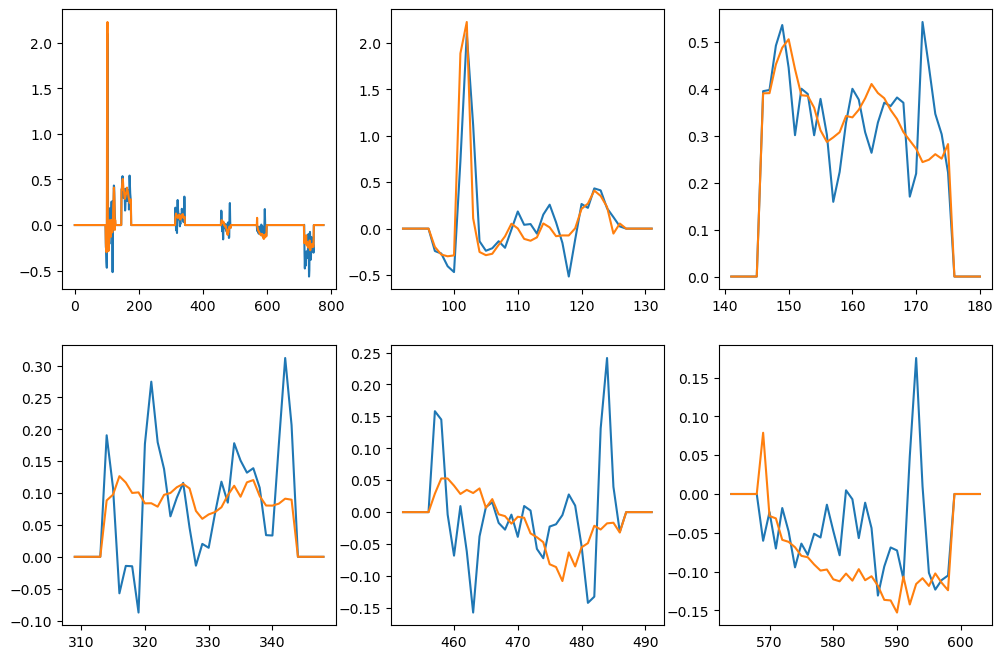

In [5]:
# set pytorch seed
torch.manual_seed(0)

# start a 2x3 figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# flatten the axs array
axs = axs.flatten()

sample = collator([ds['test'][1]])

x,y = sample['x'].squeeze(), sample['y'].squeeze()

pred = model(**sample)['preds'].squeeze()


input_ = x[1:,2:].mean(1)
target_ = y[1:,2:].mean(1)
pred_ = pred[1:,2:].data.mean(1)
loc = np.float32(input_!= target_)

axs[0].plot(target_*loc)
axs[0].plot(pred_*loc)
# plt.show()

start = loc.argmax()
for i in range(5):

    axs[i+1].plot(range(start-5,start+35), (target_*loc)[start-5:start+35])
    axs[i+1].plot(range(start-5,start+35), (pred_*loc)[start-5:start+35])
    start = start+30 + loc[start+30:].argmax()
    # plt.show()

Override the forward of the model to get all the intermediate embeddings

In [6]:
    import torch.nn.functional as F
    
    def forward(
        self, x: torch.Tensor, y: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        device = x.device
        t = x.shape[1]

        # find the mask locations
        locs = x != y

        if t > self.config.block_size:
            raise ValueError(
                f"Cannot forward sequence of length {t}, "
                f"block size is only {self.config.block_size}"
            )
        pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

        # forward the GPT model itself
        data_emb = self.data_embed(x)  # to shape (b, t, embedding_dim)
        pos_emb = self.position_embed(pos)  # to shape (t, embedding_dim)

        x = self.dropout(data_emb + pos_emb)
        embeddings = []
        for block in self.blocks:
            x = block(x)
            embeddings.append(x.detach().clone())
        x = self.final_layernorm(x)

        preds = self.head(x)
        if y is not None:
            # if we are given some desired targets also calculate the loss
            locs = locs.type_as(preds)
            loss = F.mse_loss(preds * locs, y * locs, reduction="mean") / locs.mean()
        else:
            loss = None

        return {"preds": preds, "loss": loss, "embeddings": embeddings}

    model.forward = forward.__get__(model, type(model))

In [10]:
class seq_decoder(nn.Module):

    def __init__(self, num_layers=6, embed_dim=128, nhead=4, model_embed_dim=768):
        super().__init__()

        self.num_layers = num_layers

        self.queries = nn.ParameterList([nn.Parameter(torch.randn(1, 1, embed_dim)) for i in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(embed_dim=embed_dim, num_heads=nhead, batch_first=True, kdim=model_embed_dim, vdim=model_embed_dim) for _ in range(num_layers)])
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, model, sample):

        embeddings = model(**sample)['embeddings'][-self.num_layers:]
        batch_size = len(sample['x'])

        out = 0

        for query,attention,embedding in zip(self.queries, self.attentions, embeddings):
            
            out += attention(query=query.repeat(batch_size,1,1), key=embedding, value=embedding, need_weights=False)[0]

        return self.layernorm(out).squeeze()


my_decoder = seq_decoder()      

num_params = sum(p.numel() for p in my_decoder.parameters())
print(f"{num_params:,}")

1,380,352


In [11]:
def no_mask_collator(batch):
    x = torch.tensor([b['x'] for b in batch])
    return {'x':x}

sample = no_mask_collator([ds['test'][i] for i in range(8)])
my_decoder(model=model, sample=sample).shape

torch.Size([8, 128])